# Publishing Figures - Single Kappa
This obtains all figures for a comparison between two simulations of neighbouring optical depth that only require the surface variables.

In [369]:
import copy
import sys
import os
# REMOTE - So can access functions in isca_tools which is in home/Isca directory
# sys.path.append(os.path.join(os.environ['HOME'], 'Isca'))
# LOCAL - So can access functions in isca_tools which is in StAndrews/Isca
sys.path.append(os.environ['PWD'])
import isca_tools
from isca_tools.utils.moist_physics import moist_static_energy, clausius_clapeyron_factor, sphum_sat
from isca_tools.utils.constants import kappa, L_v, c_p
from isca_tools.utils import area_weighting
from isca_tools.papers.byrne_2021 import get_quant_ind
from isca_tools.thesis.aquaplanet_theory import get_delta_temp_quant_theory, get_gamma
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import scipy.optimize
from tqdm import tqdm
from scipy import integrate
import numpy_indexed
from scipy.stats import percentileofscore
import copy
# Use custom matplotlib style for publishing
plt.style.use('/Users/joshduffield/Documents/StAndrews/Isca/jobs/tau_sweep/aquaplanet/publish_figures/publish.mplstyle')

In [280]:
# Load dataset - one at surface and one in free troposphere
var_keep = ['temp', 'sphum', 'height', 'swdn_toa']        # only keep variables required to compute relative humidity and MSE
# Load dataset
tau_lw_ref = 1
tau_lw_warm = 1.5
exp_dir = 'tau_sweep/aquaplanet/'
exp_names = [f"k={str(tau_lw_ref).replace('.','_')}", f"k={str(tau_lw_warm).replace('.','_')}"]
n_exp = len(exp_names)
ds = []
albedo = []
tau_sw = []
tau_lw = []
for i in range(n_exp):
    ds_use = isca_tools.load_dataset(exp_dir + exp_names[i])[var_keep]
    ds += [ds_use.sel(pfull=np.inf, method='nearest')]      # only keep the surface values
    namelist = isca_tools.load_namelist(exp_dir + exp_names[i])  # Need this for albedo_value
    albedo += [namelist['mixed_layer_nml']['albedo_value']]
    tau_sw += [namelist['two_stream_gray_rad_nml']['atm_abs']]
    tau_lw += [namelist['two_stream_gray_rad_nml']['odp']]
p_surface = float(ds[0].pfull) * 100

## Get datasets
Get one dataset for summer for each $\kappa$, combining all latitudes: `ds_all`. This combines the all or just tbe summer months in each hemisphere, e.g. negative latitudes will only correspond to times in December, January or February.

In [409]:
# If true, will save all figures to desktop - option to save specific figures later on.
save_fig = False
# if publishing figure, use high dpi
publish_fig = True

ar = 4/3        # aspect ratio (width/height)
# Details required for Journal of Climate Figures
low_dpi = 100
dpi = {'monochrome': 1100, 'combination': 800, 'halftone': 300}
width = {'one_col': 3.2, 'two_col': 5.5}        # width in inches 
save_pad_inches = 0.05

# Default parameters
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
ax_linewidth = plt.rcParams['axes.linewidth']

In [282]:
# Load in across all latitudes, for given season
use_time_start = 360*2

# Chose whether to only consider summer days or consider all days
summer_months = {'nh': [6, 7, 8], 'sh': [12, 1, 2]}   # JJA for NH and DJF for SH
season = 'all'
# season = 'summer'   # NOTE - if summer, does not give many days corresponding to high percentiles as only 5 years of data used

ds_all = []
with tqdm(total=n_exp, position=0, leave=True) as pbar:
    for i in range(n_exp):
        ds_use = ds[i].sel(time=slice(use_time_start, np.inf))

        if season == 'summer':
            ds_nh_summer = isca_tools.utils.annual_time_slice(ds_use, summer_months['nh']).sel(lat=slice(0, 90))  
            ds_sh_summer = isca_tools.utils.annual_time_slice(ds_use, summer_months['sh']).sel(lat=slice(-90, 0)) 
            # Combine hemispheres and average over longitude, time and latitude.
            ds_use = xr.concat([ds_sh_summer, ds_nh_summer], dim='lat')
        ds_use = ds_use.stack(lon_time=("lon","time"), create_index=False).chunk(dict(lon_time=-1))
        ds_all += [ds_use.load()]
        pbar.update(1)

100%|██████████| 2/2 [00:05<00:00,  2.64s/it]


In [283]:
# Get all data needed to compute theoretical temp change and to plot actual temp change for each quantile of temperature
quant_plot = np.arange(1, 100)     # avoid 0 quantile as it gives weird results
n_quant = len(quant_plot)
n_lat = ds_all[0].lat.shape[0]
lat_weights = np.cos(np.deg2rad(ds_all[0].lat))     # latitude area weighting is just the cosine

temp_mean = np.zeros((n_exp, n_lat))
sphum_mean = np.zeros((n_exp, n_lat))
mse_mean = np.zeros((n_exp, n_lat))
r_mean = np.zeros((n_exp, n_lat))

# quant2 is the actual quantile value rather than the average above a given quantile
temp_quant2 = np.zeros((n_exp, n_lat, n_quant))
# specific humidity as function of specific humidity quantile not temp quantile
sphum_quant2 = np.zeros((n_exp, n_lat, n_quant))
# mse as function of mse quantile not temp quantile
mse_quant2 = np.zeros((n_exp, n_lat, n_quant))

for i in tqdm(range(n_exp)):
    temp_mean[i] = ds_all[i].temp.mean(dim='lon_time')
    sphum_mean[i] = ds_all[i].sphum.mean(dim='lon_time')
    mse_mean[i] = moist_static_energy(ds_all[i].temp, ds_all[i].sphum, ds_all[i].height).mean(dim='lon_time')
    r_mean[i] = 100 * (ds_all[i].sphum/sphum_sat(ds_all[i].temp, p_surface)).mean(dim='lon_time')

    temp_quant2[i] = ds_all[i].temp.quantile(quant_plot/100, dim='lon_time', keep_attrs=True).transpose()
    sphum_quant2[i] = ds_all[i].sphum.quantile(quant_plot/100, dim='lon_time', keep_attrs=True).transpose()
    mse = moist_static_energy(ds_all[i].temp, ds_all[i].sphum, ds_all[i].height)
    mse_quant2[i] = mse.quantile(quant_plot/100, dim='lon_time', keep_attrs=True).transpose()

100%|██████████| 2/2 [00:04<00:00,  2.06s/it]


## Ocean to Ocean Mean changes in Temperature, Specific Humidity, MSE
Attempt to reproduce Byrne 2021 Figure 3, applied to an aquaplanet.

This shows that the scaling, $\lambda(p) = \frac{\delta h(p)}{\delta \overline{h}}$, is very close to 1 for all percentiles.

In [711]:
# Select region to combine latitudes over for all but one of the plots below
# Tropics
# region = 'tropics'
# lat_min = 0
# lat_max = 20
# Extratropics
# region = 'midlat'
# lat_min = 40
# lat_max = 65
# Poles
region = 'highlat'
lat_min = 70
lat_max = 90
# Global
# region = 'Global'
# lat_min = 0
# lat_max = 90

lat_use = np.where((np.abs(ds_all[0].lat) <= lat_max) & (np.abs(ds_all[0].lat) >= lat_min))[0]
lat_weights_use = lat_weights[lat_use]

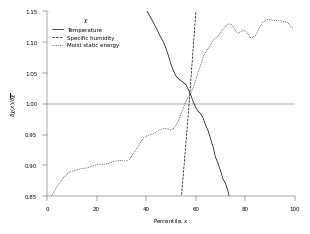

In [712]:
save_lambda_fig = False
fig, ax = plt.subplots(1,1, figsize=(width['one_col'], width['one_col']/ar))
labels = ['Temperature','Specific humidity', 'Moist static energy']
# Divide by the difference in the mean not by the difference in the median because from the above plot, the percentile p_x=50 for
# MSE does not have a corresponding temperature percentile, x.
delta_var_mean = [np.expand_dims(var[1] - var[0], axis=-1) for var in [temp_mean, sphum_mean, mse_mean]]
linestyles = ['-', '--', ':']
for i, var in enumerate([temp_quant2, sphum_quant2, mse_quant2]):
    var_ratio = ((var[1]-var[0])/delta_var_mean[i])
    ax.plot(quant_plot, np.average(var_ratio[lat_use], axis=0, weights=lat_weights_use), label=labels[i], color='k', linestyle=linestyles[i])
delta_mse_ratio = var_ratio
ax.hlines(1,0,100, color='k', linewidth=ax_linewidth)
ax.legend(title='$\chi$')
ax.set_xlabel('Percentile, $x$')
ax.set_ylabel('$\delta \chi(x)/\delta \overline{\chi}$')
ax.set_ylim(0.85,1.15)
ax.set_xlim(0, 100)
if save_fig or save_lambda_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/lambda_{region.lower()}_{season}.pdf",
                dpi=dpi['monochrome'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)

## Equating Percentiles Approximation 

This plot investigates whether $\delta h(x_h) \approx c_p \delta T(x_T) + L_v \delta q(x_q)$ is valid.

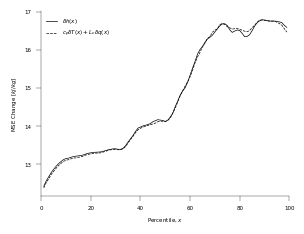

In [713]:
save_delta_mse_fig = False
fig, ax = plt.subplots(1,1, figsize=(width['one_col'], width['one_col']/ar))
ax.plot(quant_plot, np.average((mse_quant2[1]-mse_quant2[0])[lat_use], axis=0, weights=lat_weights_use), label = '$\delta h(x)$', color='k')
ax.plot(quant_plot, np.average((c_p * (temp_quant2[1]-temp_quant2[0]) +
                               L_v * (sphum_quant2[1]-sphum_quant2[0]))[lat_use], axis=0, weights=lat_weights_use)/1000,
        label='$c_p \delta T(x) + L_v \delta q(x)$', color='k', linestyle='--')
ax.legend()
ax.set_xlabel('Percentile, $x$')
ax.set_ylabel('MSE Change [$kJ/kg$]')
ax.set_xlim(0,100)

if save_fig or save_delta_mse_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/delta_mse_{region.lower()}_{season}.pdf", 
                dpi=dpi['monochrome'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)

## Theoretical Temperature Change
Below, we plot whether the theory can correctly predict the temperature change between adjacent simulations.

In [714]:
temp_diff_theory = {method: np.zeros((n_lat, n_quant)) for method in ['linear', 'const_rh', 'squared', 'squared_lambda']}
for method in temp_diff_theory:
    for i in range(n_lat):
        temp_diff_theory[method][i] = \
            get_delta_temp_quant_theory(temp_mean[:, i], sphum_mean[:, i], temp_quant2[:, i], sphum_quant2[:, i], p_surface,
                                        const_rh=True if method=='const_rh' else False,
                                        delta_mse_ratio=delta_mse_ratio[i:i+1] if 'lambda' in method else None,
                                        taylor_level='squared' if method[0] == 's' else 'linear_rh_diff')


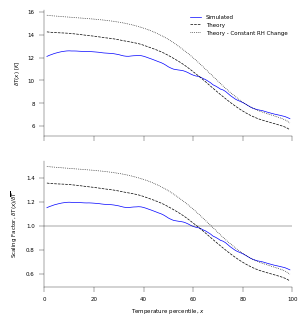

In [715]:
scaling_factor_av = 'mean'    # Mean will use quantile closest to mean at each latitude for theory
# scaling_factor_av = 'median'  # take median as average rather than mean because theory does not predict change to mean temperature
# scaling_factor_av_type = 'theory'
scaling_factor_av_type = 'simulated'     # If 'simulated', will use theoretical mean/median temp diff to compute theoretical scale factor too
av_quant_ind = np.where(quant_plot==50)[0]
if scaling_factor_av == 'mean':
    # Find temperature quantile if historical climate closest to mean
    av_quant_ind = [int(np.round(scipy.stats.percentileofscore(ds_all[0].temp[i], float(ds_all[0].temp[i].mean())))) for i in range(n_lat)]
else:
    av_quant_ind = [50]*n_lat
av_quant_ind = numpy_indexed.indices(quant_plot, np.asarray(av_quant_ind))
av_quant_flat_ind = np.ravel_multi_index((np.arange(n_lat), av_quant_ind), temp_quant2[0].shape)
sf_denom = {key: temp_diff_theory[key].flatten()[av_quant_flat_ind] for key in temp_diff_theory.keys()}
if scaling_factor_av == 'mean':
    sf_denom['simulated'] = temp_mean[1]-temp_mean[0]
else:
    sf_denom['simulated'] = (temp_quant2[1]-temp_quant2[0]).flatten()[av_quant_flat_ind]
for key in sf_denom:
    sf_denom[key] = np.expand_dims(sf_denom[key], axis=-1)
if scaling_factor_av_type == 'simulated':
    for key in temp_diff_theory.keys():
        # Set all theoretical mean/median predictions to the simulated
        sf_denom[key] = sf_denom['simulated'] 
    
    
save_theory_fig = False
fig, ax = plt.subplots(2,1, figsize=(width['one_col'], 0.75*2*(width['one_col']/ar)), sharex=True)
ax[0].plot(quant_plot, np.average((temp_quant2[1]-temp_quant2[0])[lat_use], axis=0, weights=lat_weights_use),
           label = 'Simulated', color='blue')
ax[0].plot(quant_plot, np.average(temp_diff_theory['linear'][lat_use], axis=0, weights=lat_weights_use), color='k', linestyle='--',
           label='Theory')
ax[0].plot(quant_plot, np.average(temp_diff_theory['const_rh'][lat_use], axis=0, weights=lat_weights_use), color='k',
           label='Theory - Constant RH Change', linestyle=':')
ax[1].plot(quant_plot, np.average(((temp_quant2[1]-temp_quant2[0])/sf_denom['simulated'])[lat_use],
                                  axis=0, weights=lat_weights_use), label = 'Simulated', color='b')
ax[1].plot(quant_plot, np.average((temp_diff_theory['linear']/sf_denom['linear'])[lat_use], axis=0,
                                  weights=lat_weights_use), color='k', linestyle='--')
ax[1].plot(quant_plot, np.average((temp_diff_theory['const_rh']/sf_denom['const_rh'])[lat_use], axis=0,
                                  weights=lat_weights_use), color='k', label='Theory - Constant RH Change', linestyle=':')
ax[1].hlines(1, -10, 100, color='k', linewidth=ax_linewidth)
ax[0].legend()
ax[1].set_xlabel('Temperature percentile, $x$')
ax[0].set_ylabel('$\delta T(x)$ [$K$]')
ax[1].set_ylabel('Scaling Factor, $\delta T(x) / \delta \overline{T}$')
ax[0].set_xlim(0,100)
# ax[1].set_ylim(0.8, 1.5)
# ax[0].set_ylim(3.5, 6.5)
# ax[0].set_ylim(4, 5.6)
# ax[1].set_ylim(0.89, 1.25)

if save_fig or save_theory_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/theory_{region.lower()}_{season}.pdf",
                dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)

In [696]:
# Print percentile corresponding to mean of near-surface temperature averaged over region
np.round(np.average(av_quant_ind[lat_use], weights=lat_weights[lat_use])+1)

44.0

### Gamma, $\gamma$, Plots
The dashed theory above is given by $\delta T(x) = \gamma^T \delta \overline{T} + \gamma^{\Delta r} \delta (\overline{r}-r(x))$ and the dotted line is just $\gamma^T \delta \overline{T}$. The plots below show how these $\gamma$ factors vary with percentile.

In [697]:
gamma_t = np.zeros((n_lat, n_quant))
gamma_rdiff = np.zeros((n_lat, n_quant))
for i in range(n_lat):
    all_gamma = get_gamma(temp_mean[:, i], sphum_mean[:, i], temp_quant2[:, i], sphum_quant2[:, i], p_surface)
    gamma_t[i] = all_gamma[0][0]
    gamma_rdiff[i] = all_gamma[1][0]

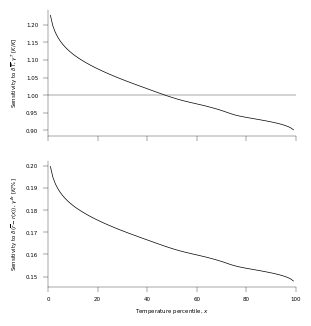

In [698]:
save_gamma_fig = False
fig, ax = plt.subplots(2,1, figsize=(width['one_col'], 0.75*2*(width['one_col']/ar)), sharex=True)
ax[0].plot(quant_plot, np.average(gamma_t[lat_use], axis=0, weights=lat_weights_use), color='k')
ax[1].plot(quant_plot, np.average(gamma_rdiff[lat_use]/100, axis=0, weights=lat_weights_use), color='k')
ax[0].hlines(1, -10, 100, color='k', linewidth=ax_linewidth)
ax[0].set_ylabel('Sensitivity to $\delta \overline{T}$, $\gamma^T$ [$K/K$]')
ax[1].set_ylabel('Sensitivity to $\delta (\overline{r} - r(x))$, $\gamma^{\Delta r}$ [$K/$%]')
ax[0].set_xlim(0,100)
ax[-1].set_xlabel('Temperature percentile, $x$')
if save_fig or save_gamma_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/gamma_{region.lower()}_{season}.pdf",
                dpi=dpi['monochrome'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)

## Failure of Theory
Below, I plot a hierarchy of theories to see which approximation causes the breakdown of the theory.
There are three approximations that go into the theory:
1. $\lambda = \delta h(x)/\delta \overline{h} = 1$

    The validity of this is shown by the green line in the $\delta \chi/\delta \overline{\chi}$ plot. This should be equal to 1.
    In the top plot below, we see that whenever $\lambda < 1$, the green line, which includes the exact $\lambda$, predicts a smaller temperature change than the orange line which is the same apart from assuming $\lambda=1$.

2. $\delta h(x) \approx c_p \delta T(x) + L_v \delta q(x)$

    The validity of this is shown in the MSE Change plot. If this approximation was exact, we would expect the solid and dashed lines to match up exactly.
   In the top plot below, we see that whenever $c_p \delta T(x) + L_v \delta q(x) > \delta h(x)$, the predicted temperature change by the most complete theory (green line) is less than the actual simulated value (blue line).

3. Taylor series for $\delta q(x)$ in terms of $\delta T(x)$ and $\delta r(x)$ as well as for $\delta \overline{q}$

    The most accurate taylor series I use is to include squared, $\delta T^2$, nonlinear, $\delta T \delta r$, and linear terms. The extent to which just the linear terms are necessary can be evaluated by comparing the orange and black dashed line below. The only difference between them is that the orange line retains all the terms in the taylor series.

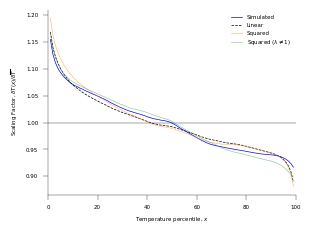

In [699]:
save_approx_fig = False
fig, ax = plt.subplots(1,1, figsize=(width['one_col'], width['one_col']/ar), sharex=True)
ax.plot(quant_plot, np.average(((temp_quant2[1]-temp_quant2[0])/sf_denom['simulated'])[lat_use],
                                  axis=0, weights=lat_weights_use), label = 'Simulated', color='b')
ax.plot(quant_plot, np.average((temp_diff_theory['linear']/sf_denom['linear'])[lat_use], axis=0,
                                  weights=lat_weights_use), color='k', linestyle='--', label='Linear')
ax.plot(quant_plot, np.average((temp_diff_theory['squared']/sf_denom['squared'])[lat_use], axis=0,
                                  weights=lat_weights_use), color=default_colors[1], alpha=0.5, label='Squared')
ax.plot(quant_plot, np.average((temp_diff_theory['squared_lambda']/sf_denom['squared_lambda'])[lat_use],
                                  axis=0, weights=lat_weights_use), color=default_colors[2], alpha=0.5, label='Squared ($\lambda \\neq 1$)')

ax.hlines(1, -10, 100, color='k', linewidth=ax_linewidth)
ax.legend()
ax.set_xlabel('Temperature percentile, $x$')
ax.set_ylabel('$\delta T(x)$ [$K$]')
ax.set_ylabel('Scaling Factor, $\delta T(x) / \delta \overline{T}$')
ax.set_xlim(0,100)

if save_fig or save_approx_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/temp_approx_{region.lower()}_{season}.pdf",
                dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)

## Relative Humidity
Below, I plot how the relative humidity changes between the simulations for each quantile. Whenever the change in relative humidity on a percentile $x$ day is less than on the mean day, $\delta (\bar{r} - r) > 0$, we get a positive contribution to $\delta T$.

Note, that this relative humidity is not a physical quantity. $r(x)$ is equal to the $x$ percentile of specific humidity, $q(x)$, divided by the saturation specific humidity evaluated on the $x$ percentile temperature day, $q_{sat}(T(x))$.

In [700]:
r_mean2 = sphum_mean / sphum_sat(temp_mean, p_surface) * 100
r_quant2 = sphum_quant2 / sphum_sat(temp_quant2, p_surface) * 100

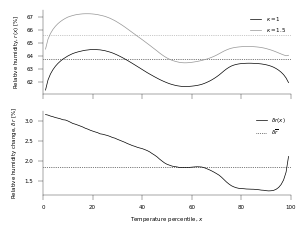

In [701]:
save_rh_fig = False
# choose which mean rh to plot - r_mean is mean over all RH values. r_mean2 is mean sphum divided by sphum_sat evaluated at mean temp.
# r_mean_use = r_mean
r_mean_use = r_mean2
color_seq_rh = plt.cm.Greys(np.linspace(0,1,n_exp+1))[1:][::-1]
fig, ax = plt.subplots(2,1, figsize=(width['one_col'], (width['one_col']/ar)), sharex=True)
for i in range(n_exp):
    ax[0].plot(quant_plot, np.average(r_quant2[i, lat_use], axis=0, weights=lat_weights_use),
               color=color_seq_rh[i], label=f'$\kappa={tau_lw[i]}$')
    ax[0].hlines(np.average(r_mean_use[i, lat_use], weights=lat_weights_use), 0, 100, color=color_seq_rh[i], linestyle=':')
ax[1].plot(quant_plot, np.average((r_quant2[1]-r_quant2[0])[lat_use], axis=0, weights=lat_weights_use), color='k', label='$\delta r(x)$')
ax[1].hlines(np.average((r_mean_use[1]-r_mean_use[0])[lat_use], axis=0, weights=lat_weights_use), 0, 100, color='k', 
             linestyles=':', label='$\delta \overline{r}$')
ax[0].set_xlim(0,100)
ax[-1].set_xlabel('Temperature percentile, $x$')
ax[0].set_ylabel('Relative humidity, $r(x)$ [%]')
ax[1].set_ylabel('Relative humidity change, $\delta r$ [%]')
ax[0].legend(frameon=False)
ax[1].legend(frameon=False)

if save_fig or save_rh_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/rh_{region.lower()}_{season}.pdf",
                dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)

## Specific humidity
Below, I plot the specific humidity in the reference (colder) simulation as a function of percentile. The fact that this increases with x is the reason we see suppressed warming of the hottest days.

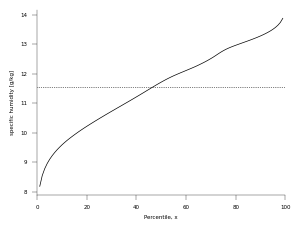

In [702]:
save_sphum_fig = False
include_mean = True
fig, ax = plt.subplots(1,1, figsize=(width['one_col'], width['one_col']/ar))
ax.spines[['right', 'top']].set_visible(False)
ax.plot(quant_plot, np.average(sphum_quant2[0, lat_use], axis=0, weights=lat_weights_use)*1000, color='k', label='$q(x)$')
if include_mean:
    ax.hlines(np.average(sphum_mean[0, lat_use], weights=lat_weights_use)*1000, 0, 100, colors='k', label='$\overline{q}$', linestyle=':')
ax.set_xlim(0,100)
ax.set_ylabel('specific humidity [g/kg]')
ax.set_xlabel('Percentile, x')
if save_sphum_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/sphum_{region.lower()}_{season}.pdf",
                dpi=dpi['monochrome'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)

## Theory as function of latitude
The plot below shows how the theory works as a function of latitude for the subset of quantiles.

In [703]:
def abs_lat_av(var):
    # averages across indices with the same absolute latitude
    var_av = np.zeros(int(len(var)/2))
    for i in range(len(var_av)):
        var_av[i] = np.mean([var[i], var[-1-i]])
    return var_av[::-1]     # invert order so latitude is increasing

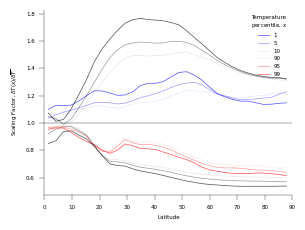

In [704]:
quant_subset_hot = [90,95,99]
quant_subset_hot_ind = numpy_indexed.indices(quant_plot, quant_subset_hot)
quant_subset_cold = [10,5,1]
quant_subset_cold_ind = numpy_indexed.indices(quant_plot, quant_subset_cold)
quant_subset_alpha = [0.1+i*(0.9/len(quant_subset_hot)) for i in range(len(quant_subset_hot))]
lat_plot = ds_all[0].lat[int(n_lat/2):]

save_theory_lat_fig = True
include_theory = True
plot_sf = True
fig_theory_lat, ax = plt.subplots(1,1, figsize=(width['one_col'], width['one_col']/ar), facecolor='w')
if include_theory:
    plot_name = f'scaling_factor_theory_lat_{season}'
    # ax.set_ylim(0.4, 1)
else:
    plot_name = f'scaling_factor_lat_{season}'
for i in range(len(quant_subset_cold))[::-1]:
    temp_plot_use = temp_quant2[1, :, quant_subset_cold_ind[i]]-temp_quant2[0, :, quant_subset_cold_ind[i]]
    temp_plot_use_theory = temp_diff_theory['linear'][:, quant_subset_cold_ind[i]]
    if plot_sf:
        temp_plot_use = temp_plot_use / sf_denom['simulated'].flatten()
        temp_plot_use_theory = temp_plot_use_theory / sf_denom['linear'].flatten()
        
    ax.plot(lat_plot, abs_lat_av(temp_plot_use), color='b', alpha=quant_subset_alpha[i], label=f'{quant_subset_cold[i]}')
    if include_theory:
        ax.plot(lat_plot, abs_lat_av(temp_plot_use_theory), color='k', alpha=quant_subset_alpha[i])
# ax.set_ylim(0.25,1.75)
for i in range(len(quant_subset_hot)):
    temp_plot_use = temp_quant2[1, :, quant_subset_hot_ind[i]]-temp_quant2[0, :, quant_subset_hot_ind[i]]
    temp_plot_use_theory = temp_diff_theory['linear'][:, quant_subset_hot_ind[i]]
    if plot_sf:
        temp_plot_use = temp_plot_use / sf_denom['simulated'].flatten()
        temp_plot_use_theory = temp_plot_use_theory / sf_denom['linear'].flatten()
    ax.plot(lat_plot, abs_lat_av(temp_plot_use), color='r',
            label=f'{quant_subset_hot[i]}', alpha=quant_subset_alpha[i])
    if include_theory:
        ax.plot(lat_plot, abs_lat_av(temp_plot_use_theory), color='k', alpha=quant_subset_alpha[i])
if plot_sf:
    ax.set_ylabel('Scaling Factor, $\delta T(x) / \delta \overline{T}$')
    ax.hlines(1, -10, 100, color='k', linewidth=ax_linewidth)
else:
    ax.plot(lat_plot, abs_lat_av(temp_mean[1]-temp_mean[0]), color='k', linestyle=':', linewidth=ax_linewidth)
    ax.set_ylabel('$\delta \overline{T}$')
ax.set_xlabel('Latitude')
ax.legend(title='Temperature\npercentile, $x$', loc='upper right')
ax.set_xlim(0,90)
if (save_fig or save_theory_lat_fig):
    fig_theory_lat.savefig(f"/Users/joshduffield/Desktop/{plot_name}.pdf",
                dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)

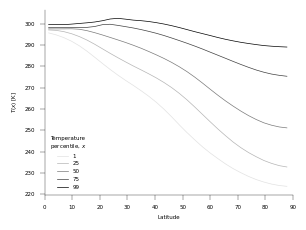

In [607]:
# For the reference k=1 simulation, plot quantiles of temperature as function of latitude
quant_ref_subset = [1, 25, 50, 75, 99]
quant_ref_subset_ind = numpy_indexed.indices(quant_plot, quant_ref_subset)
quant_ref_colors = plt.cm.Greys(np.linspace(0,1,len(quant_ref_subset)+1))[1:]

save_temp_lat_figure = False
fig, ax = plt.subplots(1,1, figsize=(width['one_col'], width['one_col']/ar))
ax.spines[['right', 'top']].set_visible(False)
for i in range(len(quant_ref_subset)):
    ax.plot(lat_plot, abs_lat_av(temp_quant2[0, :, quant_ref_subset_ind[i]]), label=f'{quant_ref_subset[i]}',
            color=quant_ref_colors[i])
# ax.plot(lat_plot, abs_lat_av(temp_quant2[0, :, av_quant_ind[0]]), color='k', 
#         label=f'${quant_plot[av_quant_ind[0]]}$', alpha=quant_subset_alpha[1])
# ax.plot(lat_plot, abs_lat_av(temp_quant2[0, :, -1]), color='k', label=f'${quant_plot[-1]}$', alpha=quant_subset_alpha[2])
ax.legend(title='Temperature\npercentile, $x$')
ax.set_xlim(0,90)
ax.set_ylabel('$T(x)$ [K]')
ax.set_xlabel('Latitude')
# Multiply by cos because area that insolation is spread over decreases with latitude
# Show that latitude of maximum temperature is just north of where there is the most sunlight
# ax.plot(lat_plot, abs_lat_av(ds_all[0].swdn_toa.max(dim='lon_time'))*np.cos(np.deg2rad(lat_plot))/1.5)
# ax.set_ylim(220, 305)
if save_temp_lat_figure:
    fig.savefig(f"/Users/joshduffield/Desktop/temp_lat_{season}.pdf",
                dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)

In [608]:
print(f'Global Mean Near-Surface Temperature Increase from kappa={tau_lw[0]} to kappa={tau_lw[1]} is '
      f'{np.round(float(area_weighting(ds_all[1].temp).mean() - area_weighting(ds_all[0].temp).mean()), 2)}K')

Global Mean Near-Surface Temperature Increase from kappa=1 to kappa=1.5 is 5.96K
